# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from catboost import CatBoostRegressor

import timeit
import numpy as np
import matplotlib.pyplot as plt
import warnings
np.warnings = warnings
warnings.filterwarnings('ignore')

%pip install missingno
import missingno as msno

%pip install skimpy
from skimpy import skim, clean_columns

%pip install lightgbm
import lightgbm as lgb
from lightgbm import LGBMRegressor

%pip install category_encoders
import category_encoders as ce

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортируем датасет
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
# Основная информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Первые 5 строк
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# Приводим названия столбцов к змеиному стилю
df = clean_columns(df)
df.columns

16 column names have been cleaned

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

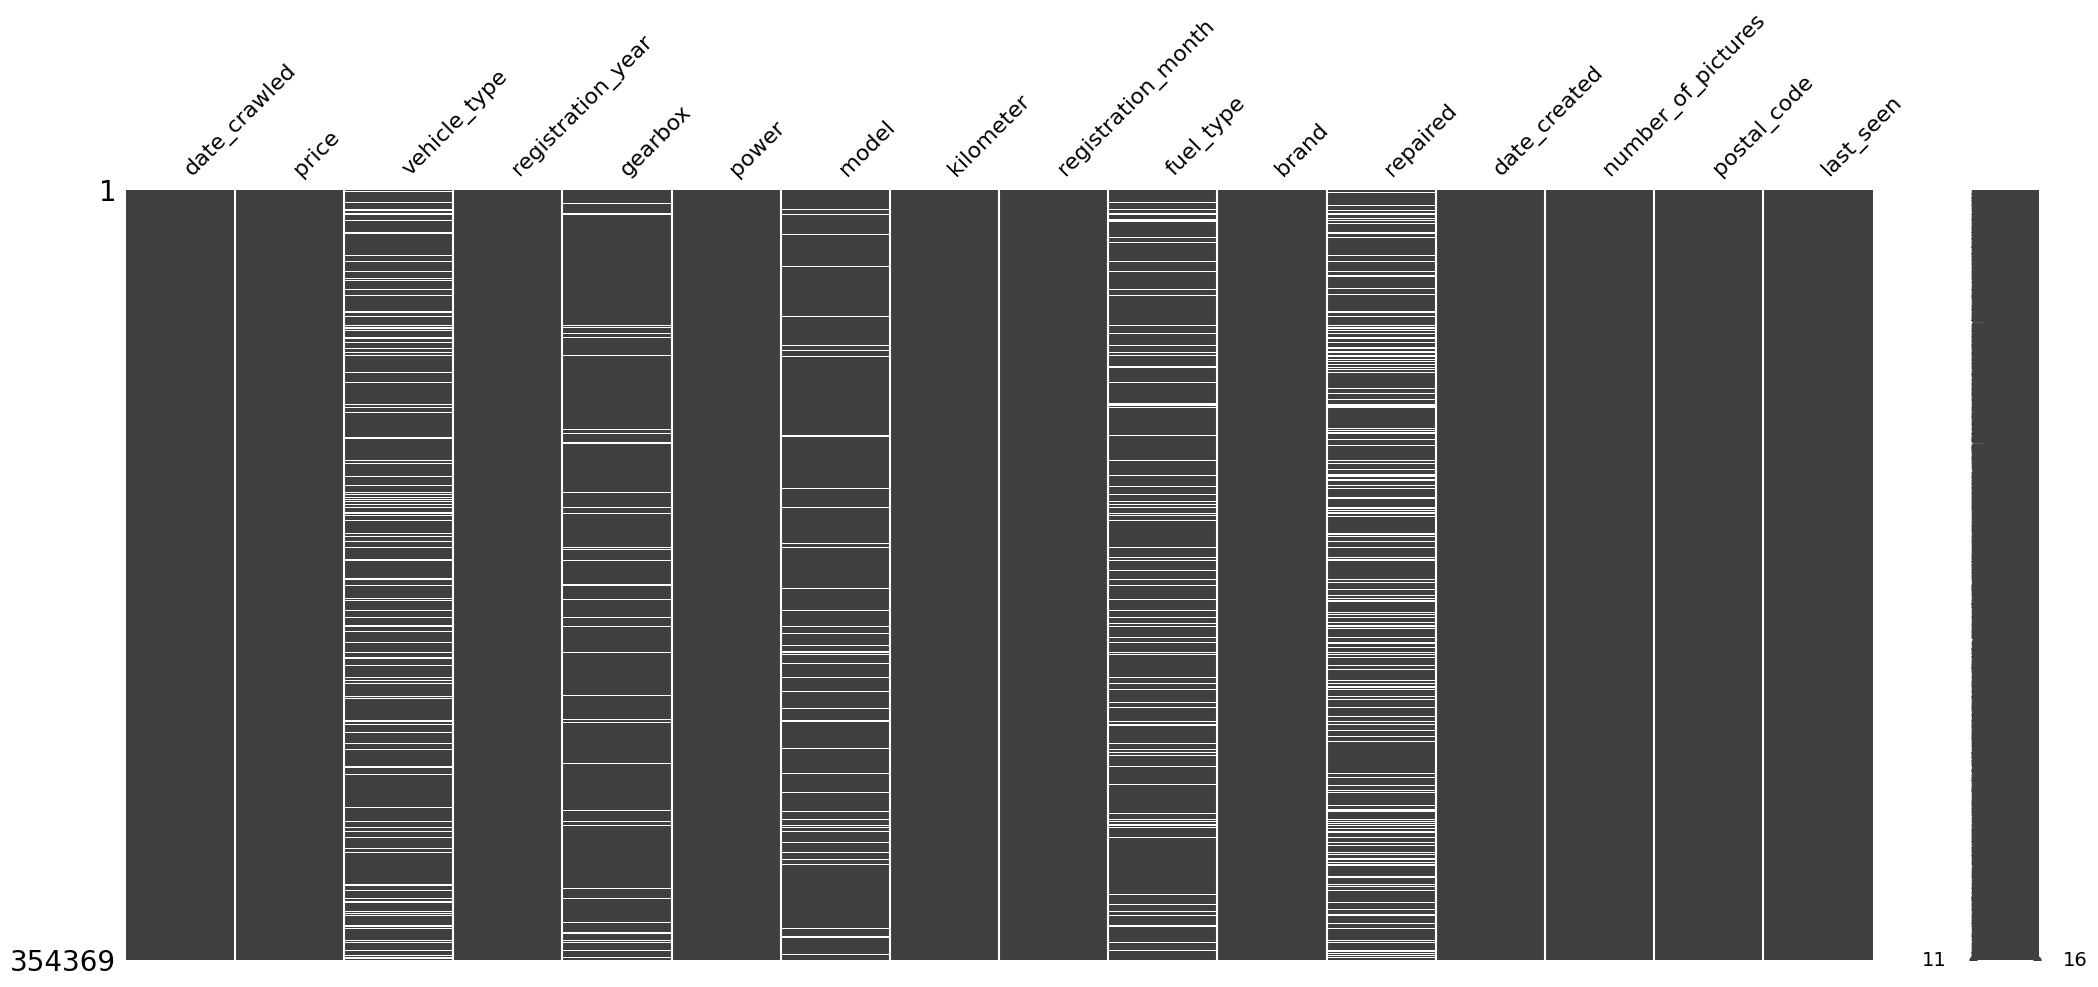

In [6]:
# Визуальное отоборажение пропусков
msno.matrix(df);

По предварительному анализу можно выделить:
1) Пропуски:
    - В столбце `vehicle_type` содержится 11% пропусков
    - В столбце `model` содержится 6% пропусков
    - В столбце `gearbox` содержится 6% пропусков
    - В столбце `fuel_type` содержится 9% пропусков
    - В столбце `repaired` содержится 20% пропусков
2) Аномальные значения:
    - В столбцах `price, power и registration_year` присуствуют аномальные значения, как аномальные низкие, так и аномально высокие
    
3) Неинформативные признаки:
    - `postal_code` — почтовый индекс владельца анкеты (пользователя)
    - `date_crawled` — дата скачивания анкеты из базы
    - `date_created` — дата создания анкеты
    - `last_seen` — дата последней активности пользователя
    - `number_of_pictures` — количество фотографий автомобиля. Этот столбец принимает только одно значение - 0. Он не информативный, поэтому удалим его.
    - `registration_month` — месяц регистрации автомобиля
    
    Информативные признаки:

    - `vehicle_type` — тип автомобильного кузова
    - `registration_year` — год регистрации автомобиля
    - `gearbox` — тип коробки передач
    - `power` — мощность (л. с.)
    - `model` — модель автомобиля
    - `kilometer` — пробег (км)
    - `fuel_type` — тип топлива
    - `brand` — марка автомобиля
    - `repaired` — была машина в ремонте или нет




Удалим неинформативные признаки.

In [7]:
# Удаляем признаки
columns_to_drop = ['date_crawled', 'date_created', 'last_seen', 'postal_code', 'number_of_pictures', 'registration_month']
df.drop(columns_to_drop, axis=1, inplace=True)

### Обработка пропусков

В столбце `vehicle_type` содержится 11% пропусков. Заполним их категорией other.

In [8]:
df['vehicle_type'].fillna('other', inplace=True)

В столбце `model` содержится 6% пропусков. Заполним их other.

In [9]:
df['model'].fillna('other', inplace=True)

В столбце `gearbox` содержится 6% пропусков. Заполним их other.

In [10]:
df['gearbox'].fillna('other', inplace=True)

В столбце `fuel_type` 9% пропусков. Сделаем то же самое.

In [11]:
df['fuel_type'].fillna('other', inplace=True)

В столбце `repaired` содержится 20% пропусков. 87% всех значений это `no`. Вероятнее пользователей не указал, была ли машина в ремонте, так как она не была в ремонте. Запонилним пропуски значениями `no`.

In [12]:
df['repaired'].fillna('no', inplace=True)

### Обработка аномальных значений

Обработаем аномальные значения в столбцах `price` и `power`. Ограничим распределение 5% и 95% квантилями для `price`. 15% и 95% для `power`. Тем самым удалив аномальные значения. 

In [13]:
df.drop(df[(df['price'] < df['price'].quantile(.05)) | (df['price'] > df['price'].quantile(.95))].index, inplace=True)

In [14]:
df.drop(df[(df['power'] < df['power'].quantile(.15)) | (df['power'] > df['power'].quantile(.95))].index, inplace=True)

В `registration_year` присуствуют аномально низкие и аномально высокие значения. Удалим их.

In [15]:
# Удаляем значения ниже 1910 и выше 2019
df.drop((df[(df['registration_year'] < 1910) | (df['registration_year'] >= 2016)]).index, inplace=True)

In [16]:
# Выводим уникальные значения столбца registration_year
df['registration_year'].sort_values().unique()

array([1910, 1937, 1941, 1942, 1943, 1948, 1949, 1950, 1951, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015], dtype=int64)

### Обработка явных дубликатов

Проверим датасет на наличие явных дубликатов.

In [17]:
df.duplicated().sum()

39279

Удалим явные дубликаты.

In [18]:
df.drop_duplicates(inplace=True)

### Подготовка датасета для обучения моделей

Создадим 2 датасета:
1) Первый датасет будет использоваться с моделью линейной регресси. Для этой модели требуется закодировать категориальные признаки. Закодируем их методами OneHotEncoding и TargetEncoding.
2) Второй датасет будет использоваться с CatBoost и LightGBM. Для этих моделей кодирование категориальных признаков не требуется. Достаточно перевести категориальные признаки в формат `category`.

In [19]:
# Датасет для линейной регрессии
df_encoded = df.copy()

# Датасет для моделей catboost и lightGBM
df_boost = df.copy()

In [20]:
# Сохраним значение random_state в отдельную переменную
state = 12345

#### Подготовка датасета для модели линейной регрессии

Разделим датасет на обучающую и тестовую выборку в соотношении 80% обучающая и 20% тестовая.

In [21]:
# Разделим датасет на обучающую и тестовую выборку
train_encoded, test_encoded = train_test_split(df_encoded, test_size=0.2, random_state=state)

In [22]:
print('Размер обучающей выборки:', train_encoded.shape)
print('Размер тестовой выборки:', test_encoded.shape)

Размер обучающей выборки: (165379, 10)
Размер тестовой выборки: (41345, 10)


In [23]:
# Обучающая выборка
train_features_encoded = train_encoded.drop(['price'], axis=1)
train_target_encoded = train_encoded['price']

# Тествая выборка
test_features_encoded = test_encoded.drop(['price'], axis=1)
test_target_encoded = test_encoded['price']

In [24]:
# Определяем список столбцов, которые требуется закодировать
columns_to_encode = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

# Создаем экземпляр OneHotEncoder из библиотеки category_encoders
encoder = ce.OneHotEncoder(cols=columns_to_encode, use_cat_names=True)

# Применяем кодирование One-Hot на обучающем наборе данных
train_features_encoded = encoder.fit_transform(train_features_encoded)

# Применяем кодирование One-Hot на тестовом наборе данных с использованием уже обученного кодировщика
test_features_encoded = encoder.transform(test_features_encoded)

In [25]:
# Удаляем первый признак из каждой категории, что бы избежать мультиколлинерности
columns_to_delete = ['vehicle_type_bus', 'gearbox_auto', 'fuel_type_cng', 'repaired_no']

# Удаляем столбцы из обучающего набора данных
train_features_encoded.drop(columns=columns_to_delete, axis=1, inplace=True)

# Удаляем столбцы из тестового набора данных
test_features_encoded.drop(columns=columns_to_delete, axis=1, inplace=True)

Что бы избежать 'проклятья размерности' воспользуеся Target Encoding для столбцов `model` и `brand`.

In [26]:
# Создаем экземпляр среднего кодирования из библиотеки category_encoders
encoder = ce.TargetEncoder(cols=['model', 'brand'])

# Применяем кодирование целевого значения на столбцах 'model' и 'brand' обучающего набора данных
encoder_train = encoder.fit_transform(train_features_encoded[['model', 'brand']],
                                      pd.DataFrame(train_target_encoded)['price'])

# Применяем кодирование целевого значения на столбцах 'model' и 'brand' тестового набора данных
encoder_test = encoder.transform(test_features_encoded[['model', 'brand']],
                                 pd.DataFrame(test_target_encoded)['price'])

# Удаляем столбцы 'model' и 'brand' из обучающего набора данных
train_features_encoded.drop(['model', 'brand'], axis=1, inplace=True)

# Удаляем столбцы 'model' и 'brand' из тестового набора данных
test_features_encoded.drop(['model', 'brand'], axis=1, inplace=True)

# Объединяем закодированные столбцы с обучающим набором данных
train_features_encoded = train_features_encoded.join(encoder_train)

# Объединяем закодированные столбцы с тестовым набором данных
test_features_encoded = test_features_encoded.join(encoder_test)

Стандартизируем признаки для закодированного датасета.

In [27]:
# Создаем объект StandardScaler
scaler = StandardScaler()

# Определяем список столбцов, которые нужно масштабировать
col_to_scale = ['power', 'kilometer', 'registration_year']

# Обучаем scaler на тренировочных данных
scaler.fit(train_features_encoded[col_to_scale])

# Масштабируем выбранные столбцы в тренировочном наборе данных
train_features_encoded[col_to_scale] = scaler.transform(train_features_encoded[col_to_scale])

# Масштабируем выбранные столбцы в тестовом наборе данных
test_features_encoded[col_to_scale] = scaler.transform(test_features_encoded[col_to_scale])

#### Подготовка датасета для моделей CatBoost и LightGBM

Для моделей CatBoost и LightGBM переведём категориальные признаки тип `category`.

In [28]:
# Столбцы с категориальными признаками
categorical_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model', 'brand']

# Преобразование выбранных столбцов в тип 'category'
df_boost[categorical_columns] = df_boost[categorical_columns].astype('category')

Разделим датасет на обучающую и тестовую выборку в соотношении 80% обучающая и 20% тестовая.

In [29]:
# Разделим датасет на обучающую и тестовую выборку
train_boost, test_boost = train_test_split(df_boost, test_size=0.2, random_state=state)

In [30]:
print('Размер обучающей выборки:', train_boost.shape)
print('Размер тестовой выборки:', test_boost.shape)

Размер обучающей выборки: (165379, 10)
Размер тестовой выборки: (41345, 10)


Разделяем на `features` и `target`.

In [31]:
# Обучающая выборка
train_features = train_boost.drop(['price'], axis=1)
train_target = train_boost['price']

# Тествая выборка
test_features = test_boost.drop(['price'], axis=1)
test_target = test_boost['price']

### Вывод по подготовке данных
На этапе предподготовки данных, были выполненые такие шаги:
- Изучили датасет
- Заполнили пропуски
- Обработали аномальные значения
- Удалили неинформативные признаки
- Удалили явные дубликаты
- Закодировали категориальные признаки прямым кодированием (One-Hot-Encoding) и Target Encoding
- Разделили датасет на обучающую и тестовую выборку
- Стандартизировали признаки

## Обучение моделей

Определяем метрику оценки производительности RMSE

In [32]:
rmse_score = make_scorer(mean_squared_error, squared=False)

Создадим таблицу, куда будем сохранять результаты, что бы в дальнейшем проанализировать их.

In [33]:
results_df = pd.DataFrame(columns=['model', 'best_rmse', 'rmse_test', 'params_time', 'predict_time'])

In [34]:
results_fit_time = pd.DataFrame(columns=['fit_time'])

Создадим функцию обучения моделей.

In [35]:
def train_model(model, params, train_features, train_target, test_features, results_df, cat_features=None):
    # Создаем объект GridSearchCV с моделью model, сеткой параметров params,
    # кросс-валидацией на 5 фолдах и оценкой по scoring-функции rmse_score
    grid = GridSearchCV(model, param_grid=params, cv=5, scoring=rmse_score)
    
    # Засекаем время начала обучения модели
    start_time = timeit.default_timer()
    
    # Обучаем модель
    if cat_features is None:
        # Если `cat_features` не указаны, то обучаем модель без учета категориальных признаков
        grid.fit(train_features, train_target)
    else:
        # Если `cat_features` указаны, то обучаем модель с учетом категориальных признаков
        grid.fit(train_features, train_target, cat_features=cat_features)
   
    # Засекаем время окончания обучения модели
    end_time = timeit.default_timer()
    
    # Получаем лучший результат и параметры из объекта GridSearchCV
    best_score = grid.best_score_
    best_params = grid.best_params_
    
    # Вычисляем время подбора гиперпараметров
    params_time = end_time - start_time
    
    # Засекаем время начала предсказания на тестовых признаках
    start_time_predict = timeit.default_timer()
    
    # Делаем предсказания на тестовых признаках
    predictions = grid.predict(test_features)
    
    # Засекаем время окончания предсказания
    end_time_predict = timeit.default_timer()
    
    # Вычисляем время предсказания
    predict_time = end_time_predict - start_time_predict
    
    # Вычисляем RMSE (среднеквадратичную ошибку) между предсказаниями и целевой переменной тестовых данных
    rmse_test = np.sqrt(mean_squared_error(test_target, predictions))
    
    # Добавляем результаты в таблицу
    results_df.loc[len(results_df)] = [model.__class__.__name__, best_score, rmse_test, params_time, predict_time]

    # Возвращаем лучшие гиперпараметры модели
    return best_params

In [36]:
# Функция вычисляющая время обучения модели
def fit_time_cal(model, train_features, train_target, best_params, results, cat_features=None, random_state=None):
    # Создаем модель с использованием переданных параметров и указанным random_state
    if random_state is None:
        model = model(**best_params)
    else:
        model = model(random_state=state, **best_params, verbose=0)

    # Засекаем время начала обучения модели
    start_time = timeit.default_timer()
    
    if cat_features is None:
        # Если `cat_features` не указаны, то обучаем модель без учета категориальных признаков
        model.fit(train_features, train_target)
    else:
        # Если `cat_features` указаны, то обучаем модель с учетом категориальных признаков
        model.fit(train_features, train_target, cat_features=cat_features)
        
    # Засекаем время окончания обучения модели
    end_time = timeit.default_timer()

    # Вычисляем время обучения
    fit_time = end_time - start_time

    # Сохраняем время обучения в столбец 'fit_time' DataFrame results_df
    results.loc[len(results)] = [fit_time]

### Модель линейной регрессии

In [37]:
# Создаем объект LinearRegression
lin_reg = LinearRegression()

# Определяем параметры для поиска по сетке
lin_params = {'fit_intercept':[True, False]}

# Вызываем функцию train_model для обучения модели с заданными параметрами
lin_best_params = train_model(
    lin_reg, lin_params, train_features_encoded, train_target_encoded, test_features_encoded, results_df
)

In [38]:
# Вызываем функцию fit_time_cal для вычисления времени обучения модели
fit_time_cal(LinearRegression, train_features_encoded, train_target_encoded, lin_best_params, results_fit_time)

In [39]:
results_df.loc[results_df['model'] == 'LinearRegression']

,model,best_rmse,rmse_test,params_time,predict_time
0,LinearRegression,2144.455585,2121.437286,1.572351,0.007366


In [40]:
print('Лучшие гиперпараметры для модели линейной регрессии:', lin_best_params)

Лучшие гиперпараметры для модели линейной регрессии: {'fit_intercept': False}


### Модель градиентного бустинга LightGBM

In [41]:
# Создаем модель LGBMRegressor с указанным random_state
lgbm_model = LGBMRegressor(random_state=state)

# Задаем параметры для гиперпараметров модели
lgbm_params = {'max_depth': [1, 2], 'n_estimators': [25, 50]}

# Вызываем функцию train_model для обучения модели с использованием указанных параметров
lgbm_best_params = train_model(lgbm_model, lgbm_params, train_features, train_target, test_features, results_df)

In [42]:
# Вызываем функцию fit_time_cal для вычисления времени обучения модели
fit_time_cal(LGBMRegressor, train_features, train_target, lgbm_best_params, results_fit_time, random_state=state)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [43]:
print('Лучшие гиперпараметры для модели LightGBM:', lgbm_best_params)

Лучшие гиперпараметры для модели LightGBM: {'max_depth': 1, 'n_estimators': 25}


In [44]:
results_df.loc[results_df['model'] == 'LGBMRegressor']

,model,best_rmse,rmse_test,params_time,predict_time
1,LGBMRegressor,2271.449517,2257.78108,3.478991,0.013825


### Модель градиентного бустинга CatBoostRegressor

In [45]:
cat_features = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model', 'brand']

In [46]:
# Создаем модель CatBoostRegressor с указанным random_state
cat_boost_model = CatBoostRegressor(random_state=state, verbose=0)

# Задаем параметры для гиперпараметров модели
cat_boost_params = {'max_depth': [4, 6],
                   'iterations': [50, 100]}

# Вызываем функцию train_model для обучения модели с использованием указанных параметров
cat_boost_best_params = train_model(
    cat_boost_model, 
    cat_boost_params, 
    train_features, 
    train_target, 
    test_features, 
    results_df, 
    cat_features
)

In [47]:
# Вызываем функцию fit_time_cal для вычисления времени обучения модели
fit_time_cal(
    CatBoostRegressor, train_features, train_target, cat_boost_best_params, results_fit_time, cat_features, random_state=state
)

In [48]:
print('Лучшие гиперпараметры для модели CatBoost:', cat_boost_best_params)

Лучшие гиперпараметры для модели CatBoost: {'iterations': 50, 'max_depth': 4}


In [49]:
results_df.loc[results_df['model'] == 'CatBoostRegressor']

,model,best_rmse,rmse_test,params_time,predict_time
2,CatBoostRegressor,1408.771347,1398.001925,85.004664,0.036508


### Вывод по обучению моделей
На этапе обучения моделей, обучили 3 модели:
- LinearRegression - Модель линейной регрессии
- LGBMRegressor - Модель градиентного бустинга LightGBM
- CatBoostRegressor	- Модель градиентного бустинга CatBoostRegressor

Результаты сохранили в таблицу `results_df`. Проанализируем и выберем лучшую модель на этапе анализа моделей.

## Анализ моделей

В этом разделе проанализируем собранные данные в таблице `results_df`.

In [50]:
# Объеденим результаты
results_df = results_df.join(results_fit_time)

In [51]:
# Создадим столбец с сумарным временем обучения и предсказания
results_df['fit_predict_time'] = results_df['fit_time'] + results_df['predict_time']

In [52]:
results_df

,model,best_rmse,rmse_test,params_time,predict_time,fit_time,fit_predict_time
0,LinearRegression,2144.455585,2121.437286,1.572351,0.007366,0.140878,0.148243
1,LGBMRegressor,2271.449517,2257.781080,3.478991,0.013825,0.168163,0.181988
2,CatBoostRegressor,1408.771347,1398.001925,85.004664,0.036508,2.931190,2.967699


In [53]:
# Функция для постороения столбчатой диаграммы
def plot_bar_chart(height, bars, title):
    # Создание массива позиций для каждого столбца на оси x
    x_pos = np.arange(len(bars))
    
    # Определение цветов для столбцов
    colors = ['blue', 'green', 'red', 'orange']
    
    # Создание нового графика с указанным размером
    plt.figure(figsize=(10, 6))
    
    # Построение столбчатой диаграммы
    plt.bar(x_pos, height, color=colors)
    
    # Установка подписей на оси x
    plt.xticks(x_pos, bars)
    
    # Включение сетки по оси y с прозрачностью 0.2
    plt.grid(True, axis='y', alpha=0.2)
    
    # Установка заголовка диаграммы
    plt.title(title)
    plt.ylabel('RMSE')
    
    # Отображение графика
    plt.show()

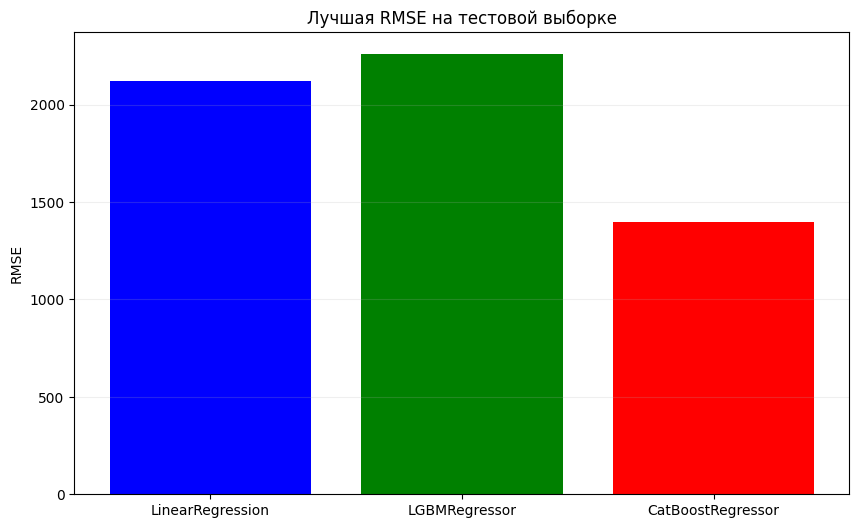

In [54]:
plot_bar_chart(results_df['rmse_test'], results_df['model'], 'Лучшая RMSE на тестовой выборке')

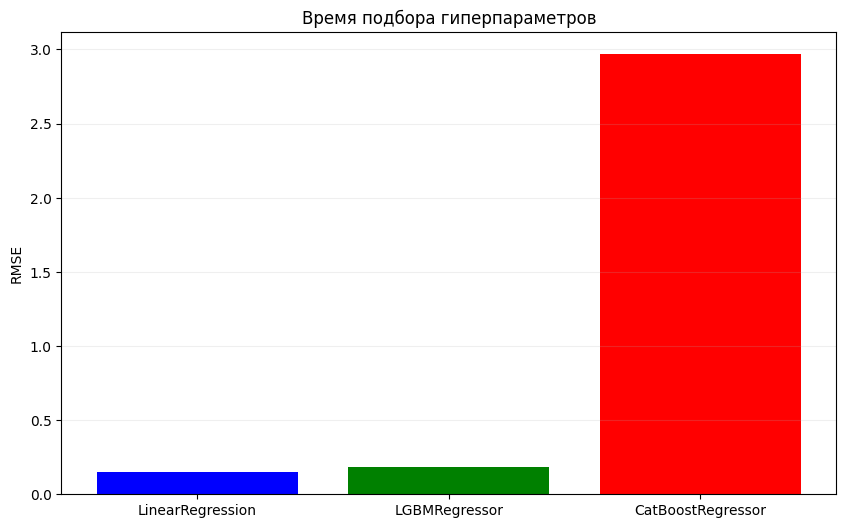

In [55]:
plot_bar_chart(results_df['fit_predict_time'], results_df['model'], 'Время подбора гиперпараметров')

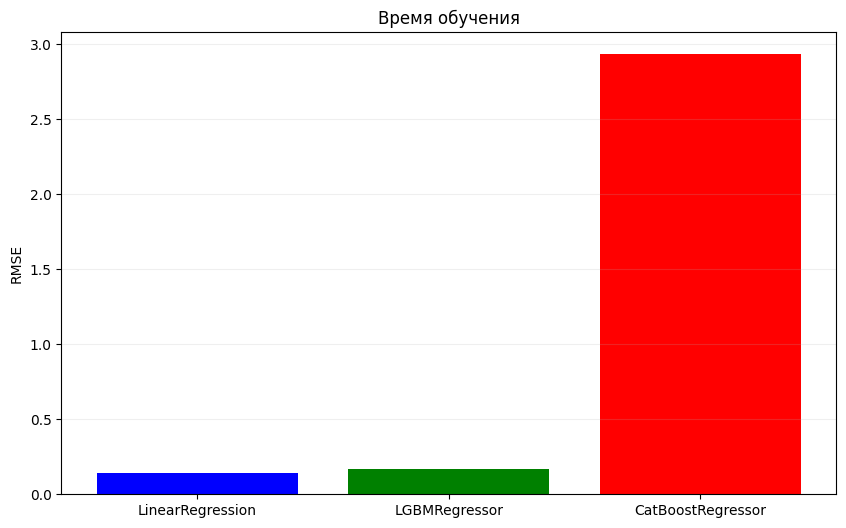

In [56]:
plot_bar_chart(results_df['fit_time'], results_df['model'], 'Время обучения')

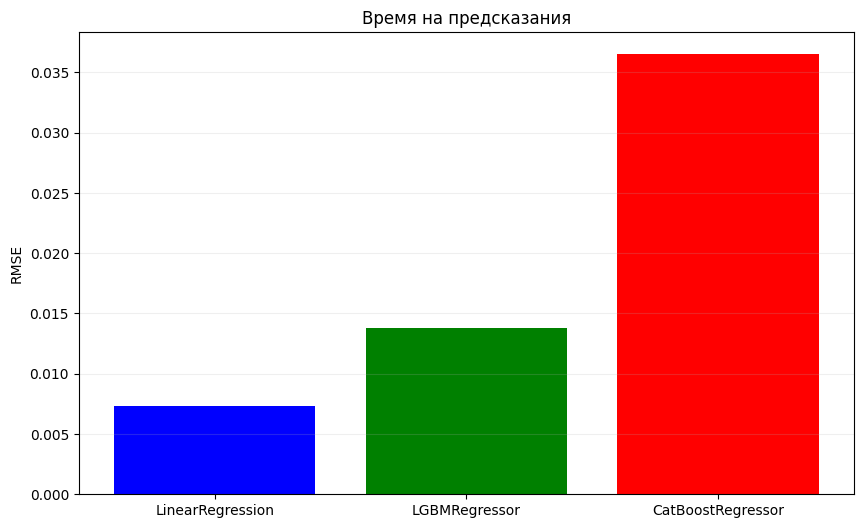

In [57]:
plot_bar_chart(results_df['predict_time'], results_df['model'], 'Время на предсказания')

### Вывод по анализу моделей

Получили такие результаты:

- Лучшее качество предсказаний у модели CatBoost
- Наибольшая скорость предсказаний у модели LinearRegression
- Наименьшее время обучения у модели LinearRegression

## Вывод по проекту

В этом проекте нам нужно было построить модель для определения рыночной стоимости автомобиля. 

В этом проекте мы сделали:
- Изучили датасет
- Заполнили пропуски
- Обработали аномальные значения
- Удалили неинформативные признаки
- Удалили явные дубликаты
- Закодировали категориальные признаки прямым кодированием (One-Hot-Encoding) и Target Encoding
- Разделили датасет на обучающую и тестовую выборку
- Стандартизировали признаки
- Обучили 3 модели:
    - LinearRegression - Модель линейной регрессии
    - LGBMRegressor - Модель градиентного бустинга LightGBM
    - CatBoostRegressor - Модель градиентного бустинга CatBoostRegressor
- Собрали результаты в таблице `results_df`
- Проанализировали модели
- Выбрали лучшую модель подходящию заказчику по 3 параметрам: по качеству предсказаний, скорость предсказаний и времени обучения.

По итогу лучшее значение RMSE у модели CatBoost, по остальным параметрам она уступает таким моделям, как LinearRegression и LightBoost.